# Example workflow to analyse the type and amount of errors for different preprocessing levels

If you are only interested in the final plots and a summary for preprocessing level 5 go to:
- [Plot and summary of findings about relative failing glacier area](#id-total-error-area-summary)
- [Comparison of errors between the different RGI regions](#id-rgi-diff)

In [31]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

cfg.initialize()

import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 8)

# makes sure that the pandas output columns are not cropped!
pd.set_option("max_colwidth", None)


2021-12-17 12:46:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-12-17 12:46:37: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-12-17 12:46:37: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [32]:
def error_analysis_w_plot(dfserr={}, pd_rel_error_area = None,
                          level='L2', exp='elev_bands', pcp ='', clim='', 
                          qc = '', match = '', border = 160,
                          rgi_reg = 'all', 
                          path = '/home/www/oggm/gdirs/oggm_v1.4/', subplot = False, xlim=None, plot=True):
    """ Estimates for a specific preprocessed gdirs the relative glacier area with errors
    and the relative amount of glaciers with errors (both in %). 
    
    Plots the error counts for the different error types.
    
    Works only if the glacier statistics were estimated!
    
    Parameters
    ----------
    dfserr : dictionary
        dictionary where already errors of largest glaciers from other preprocessed gdirs are saved, default is an empty dictionary
    pd_rel_error_area : pd.DataFrame
        pandas DataFrame with statistics about relative area and amount of errors on glaciers. 
        Default is None, which creates a new pandas DataFrame
    level : str
        the preprocessing level where the errors should be estimated and plotted.
        So far, it works only for 'L2' and 'L5'. Default is 'L2'.
    exp : str
        which glacier flowlines are used. Either 'elev_bands' (default) or 'centerlines'
    pcp : str
        precipitation factor applied (depends on clim). Has to be set!
    clim : str
        which baseline is applied. Either 'ERA5' or 'CRU'. Has to be set!
    qc : str
        whether a glacier climate quality check and correction was applied. If yes, set it to 'qc3', 
        otherwise to 'qc0'. Has to be set!
    match: str
        which calibration & other methods are chosen: Has to be set if above level 2!
        - "no_match" : only direct glaciological WGMS data used
        - "match_geod" : same as no_match, but regionally the geodetic estimates are matched by changing epsilon
        - "match_geod_pergla" : only per-glacier-individual geodetic estimates of Hugonnet et al. (2021) matched
        - "match_geod_pergla_massredis" : same as match_geod_pergla, but instead of the Shallow-Ice Approximation, 
          a mass-redistribution is applied (see: https://docs.oggm.org/en/latest/mass-redistribution.html)
    border : str
        which size of the local glacier map was used (prepro_border). For qc0, e.g., 
        most preprocessing directories are available for border=80. Default is 160
    rgi_reg : str
        default is all RGI regions. But you can also choose a single RGI region (e.g. rgi_reg = '11') or all RGI 
        regions except 19 (i.e. not available for CRU!, rgi_reg='all_without_19')
    path : str
        path to the general gdirs folder
    subplot : bool
        Default is False. If you want to use several plots, set it to True
    xlim : int
        Default is None. Maximum of single type errors in the plot. Useful for subplots
    plot : bool
        If an error type plot should be returned or not!
    
    Returns
    -------
    dfserr : dictionary
        dictionary where for each preprocessed gdir, a pd.DataFrame exists which lists the 
        type of errors and area of the 15 largest glaciers with errors
    pd_rel_error_area : pd.DataFrame
        pandas DataFrame with statistics about relative area and amount of errors on glaciers. 
        If repeated, for several preprocessed gdirs, each row represents the statistics of 
        one preprocessed gdirs.
        
    """
    if clim == 'CRU' and rgi_reg == 'all':
        raise InvalidParamsError("CRU is NOT available for RGI 19, use rgi_reg='all_without_19' instead")
    if pd_rel_error_area is None:
        pd_rel_error_area = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp', 'pcp_clim', 'match', 'qc'])

    if level == 'L2':
        fd = f'{path}/L1-L2_files/{exp}/RGI62/b_{border:03d}/L2/summary/'
        err_msg = "In preprocessing level 2, climate, precipitation factor and qc should not be defined"
        assert pcp == '' and clim == '' and qc == '', err_msg
        title = f'{level}: {exp}, border: {border}'
        dict_key = f'{level}_{exp}_b{border}_rgi_{rgi_reg}'
    elif level == 'L5':
        fd = f'{path}/L3-L5_files/{clim}/{exp}/{qc}/{pcp}/{match}/RGI62/b_{border:03d}/L5/summary/'
        err_msg = "In preprocessing level 2, need to prescribe climate (clim), match, precipitation factor (pcp) and quality check type (qc)"
        assert pcp != '' and clim != '' and qc != '' and match !='' , err_msg

        title = f'{level}: {exp}, {pcp}, {clim}, {match}, {qc}, border: {border}, rgi_{rgi_reg}'
        dict_key = f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}_rgi_{rgi_reg}'
    else:
        raise InvalidParamsError('Only L2 and L5 can be used, but the function can be adapted easily in order that it works for other levels!')
        
    # get the statistics file which lists errors and their type
    fs = glob.glob(fd+'glacier_statistics*.csv')
    
    if rgi_reg == 'all_without_19':
        for f in fs:
            if 'statistics_19' in f:
                fs.remove(f)
        assert len(fs) == 18
    elif rgi_reg == 'all':
        assert len(fs) == 19
    else:
        for f in fs:
            if f'statistics_{rgi_reg}' in f:
                fs = [f]
                break
        assert len(fs) == 1
    
    df = []
    for f in fs:
        df.append(pd.read_csv(f, index_col=0, low_memory=False))
    df = pd.concat(df).sort_index()
    
    rel_error_area = df.loc[~df['error_task'].isnull()].rgi_area_km2.sum() / df.rgi_area_km2.sum() * 100
    
    # plot the amount of errors for each error type
    if plot:
        title = title + '\n relative glacier area with errors: {:.2f}%'.format(rel_error_area)
        if not subplot:
            plt.figure()
        plt.title(title)
        sns.countplot(y="error_task", data=df.sort_values(by='error_task'));
        if xlim is not None:
            plt.xlim([0,xlim])

    # save the glaciers that result in errors sorted from largest to smallest glacier area
    dfserr[dict_key] = df.loc[~df['error_task'].isnull()].sort_values(by='rgi_area_km2', ascending=False)[['rgi_area_km2', 'error_task', 'error_msg']]
    # .iloc[:15]
    # save statistics about relative area and amount of errors on glaciers
    pd_rel_error_area.loc[dict_key] = np.NaN
    pd_rel_error_area.loc[dict_key]['rel_error_area_in_percent'] = rel_error_area
    pd_rel_error_area.loc[dict_key]['clim_pcp'] = f'{clim}_{pcp}'
    pd_rel_error_area.loc[dict_key]['rgi_reg'] = rgi_reg
    pd_rel_error_area.loc[dict_key]['level'] = level
    pd_rel_error_area.loc[dict_key]['border'] = border
    pd_rel_error_area.loc[dict_key]['exp'] = exp
    pd_rel_error_area.loc[dict_key]['match'] = match
    pd_rel_error_area.loc[dict_key]['qc'] = qc
    
    return dfserr, pd_rel_error_area

In [33]:
# could be changed, but not all pre-processed directories are available for all prepro_border options!
border = 160 # 80 if qc0
# these are just containers to save and later compare the error statistics! 
dfserr = {}
pd_rel_error_area = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp', 'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

## Analysis for Level 2 pre-processing directories!

In pre-processing level 2, we only distinguish between elevation bands and centerlines (see the [Flowlines documentation](https://docs.oggm.org/en/stable/flowlines.html#glacier-flowlines) for an explanation about the differences). 

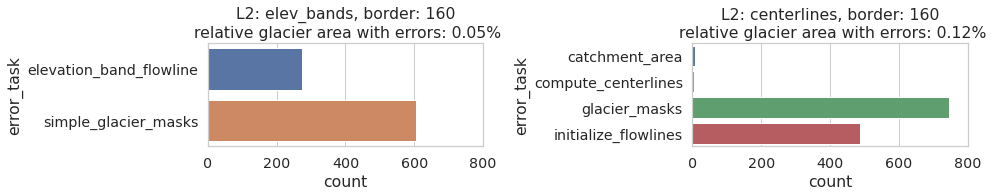

In [34]:
plt.figure(figsize=(14,3))
plt.subplot(121)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area, level='L2', subplot=True,
                                                  exp='elev_bands', border=border, xlim = 800)
plt.subplot(122)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area, level='L2',  subplot=True,
                                                  exp='centerlines', border=border, xlim = 800)
plt.tight_layout()

- failing glacier area on pre-processing level 2 is ~0.1% or less
- less glaciers will fail when using elev_bands than centerlines

**Here you can analyse the failing glaciers with the largest area and the type of error that has occurred!**

In [35]:
dfserr['L2_elev_bands_b160_rgi_all'].head()

rgi_area_km2               error_task  \
rgi_id                                                  
RGI60-10.00002        48.144     simple_glacier_masks   
RGI60-10.00006        12.966     simple_glacier_masks   
RGI60-12.01364         9.250     simple_glacier_masks   
RGI60-19.01402         7.482  elevation_band_flowline   
RGI60-19.01367         7.271  elevation_band_flowline   

                                                                      error_msg  
rgi_id                                                                           
RGI60-10.00002              GeometryError: RGI60-10.00002 is a nominal glacier.  
RGI60-10.00006              GeometryError: RGI60-10.00006 is a nominal glacier.  
RGI60-12.01364              GeometryError: RGI60-12.01364 is a nominal glacier.  
RGI60-19.01402  InvalidDEMError: (RGI60-19.01402) DEM altidude range too small.  
RGI60-19.01367  InvalidDEMError: (RGI60-19.01367) DEM altidude range too small.

In [36]:
dfserr['L2_centerlines_b160_rgi_all'].head()

rgi_area_km2            error_task  \
rgi_id                                               
RGI60-19.01521        94.963  initialize_flowlines   
RGI60-10.00002        48.144         glacier_masks   
RGI60-04.06184        40.934  initialize_flowlines   
RGI60-03.04079        35.752  initialize_flowlines   
RGI60-14.01649        30.795        catchment_area   

                                                                                      error_msg  
rgi_id                                                                                           
RGI60-19.01521     RuntimeError: Altitude range of main flowline too small: 0.11659260120634544  
RGI60-10.00002                              GeometryError: RGI60-10.00002 is a nominal glacier.  
RGI60-04.06184                                                                 AssertionError:   
RGI60-03.04079  RuntimeError: Altitude range of main flowline too small: 1.2600400626842188e-05  
RGI60-14.01649            ValueError: no minimum-cost path was found to the specified end point

Let's just look at the level 2 errors for only RGI region 12 

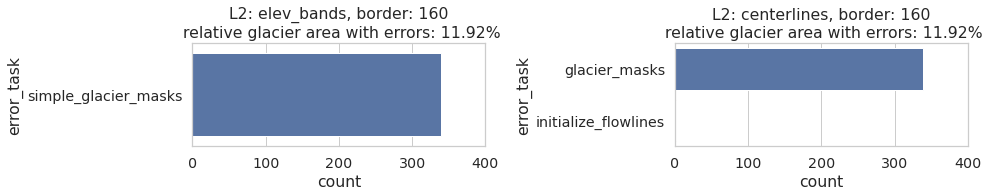

In [37]:
rgi_reg = '12'
plt.figure(figsize=(14,3))
plt.subplot(121)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area, level='L2', subplot=True,
                                                      exp='elev_bands', rgi_reg=rgi_reg,
                                                      border=border, xlim = 400)
plt.subplot(122)
dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area, level='L2',  subplot=True,
                                                      exp='centerlines', rgi_reg=rgi_reg,
                                                      border=border, xlim = 400)
plt.tight_layout()

In [38]:
dfserr['L2_elev_bands_b160_rgi_12']['error_msg']

rgi_id
RGI60-12.01364    GeometryError: RGI60-12.01364 is a nominal glacier.
RGI60-12.01372    GeometryError: RGI60-12.01372 is a nominal glacier.
RGI60-12.01374    GeometryError: RGI60-12.01374 is a nominal glacier.
RGI60-12.01500    GeometryError: RGI60-12.01500 is a nominal glacier.
RGI60-12.01443    GeometryError: RGI60-12.01443 is a nominal glacier.
                                         ...                         
RGI60-12.01628    GeometryError: RGI60-12.01628 is a nominal glacier.
RGI60-12.01545    GeometryError: RGI60-12.01545 is a nominal glacier.
RGI60-12.01546    GeometryError: RGI60-12.01546 is a nominal glacier.
RGI60-12.01547    GeometryError: RGI60-12.01547 is a nominal glacier.
RGI60-12.01350    GeometryError: RGI60-12.01350 is a nominal glacier.
Name: error_msg, Length: 339, dtype: object

In RGI region 12, ~12% of the glacier area can not run even in pre-processing level 2. The reasons are glacier masks errors because many of the glaciers in RGI region 12 are "nominal" glaciers. Nominal means here that the glaciers don't have a glacier outline but only a location and area and hence can not be run with OGGM. 

## Analysis for Level 5 pre-processing directories! 

In pre-processing level 5, we distinguish between:
- different flowline types (exp = 'elev_bands' or 'centerlines', see the [Flowlines documentation](https://docs.oggm.org/en/stable/flowlines.html#glacier-flowlines))
- different climate and precipitation factors (here: clim='CRU' with pcp='pcp2.5' or 'ERA5' with 'pcp1.6')
- different ways to calibrate the mass balance (see [documentation on available mass-balance calibration methods](https://docs.oggm.org/en/latest/input-data.html#d-option-mass-balance-calibration-method)):
    - match = "no_match" : only direct glaciological WGMS data used
    - match = "match_geod" : same as no_match, but regionally the geodetic estimates are matched by changing epsilon
    - match = "match_geod_pergla" : only per-glacier-individual geodetic estimates of Hugonnet et al. (2021) matched 
- applying the climate quality check and correction (qc='qc3') or not (qc='qc0'), see [historical_climate_qc](https://docs.oggm.org/en/latest/generated/oggm.tasks.historical_climate_qc.html#oggm.tasks.historical_climate_qc).
    - for match_geod_pergla there is only qc0 because the climate quality check and correction is done already internally (if no mu_star in the range 20-600 was found, a temperature bias is applied, see [the MB-pergla documentation](https://docs.oggm.org/en/latest/mass-balance-2012-pergla.html).
- using either the default shallow-ice approximation or a simple mass-redistribution (see: https://docs.oggm.org/en/latest/mass-redistribution.html). For the mass-redistribution, we only have one preprocessed glacier directory at the moment. You can check it out under:
    - match = 'match_geod_pergla_massredis' (same as match_geod_pergla but with mass redistribution instead of SIA)

In [39]:
level = 'L5'

### Let's start by looking only on elev_bands flowline pre-processed directories with 'qc3':

- this makes only sense for 'no_match' and for 'match_geod'

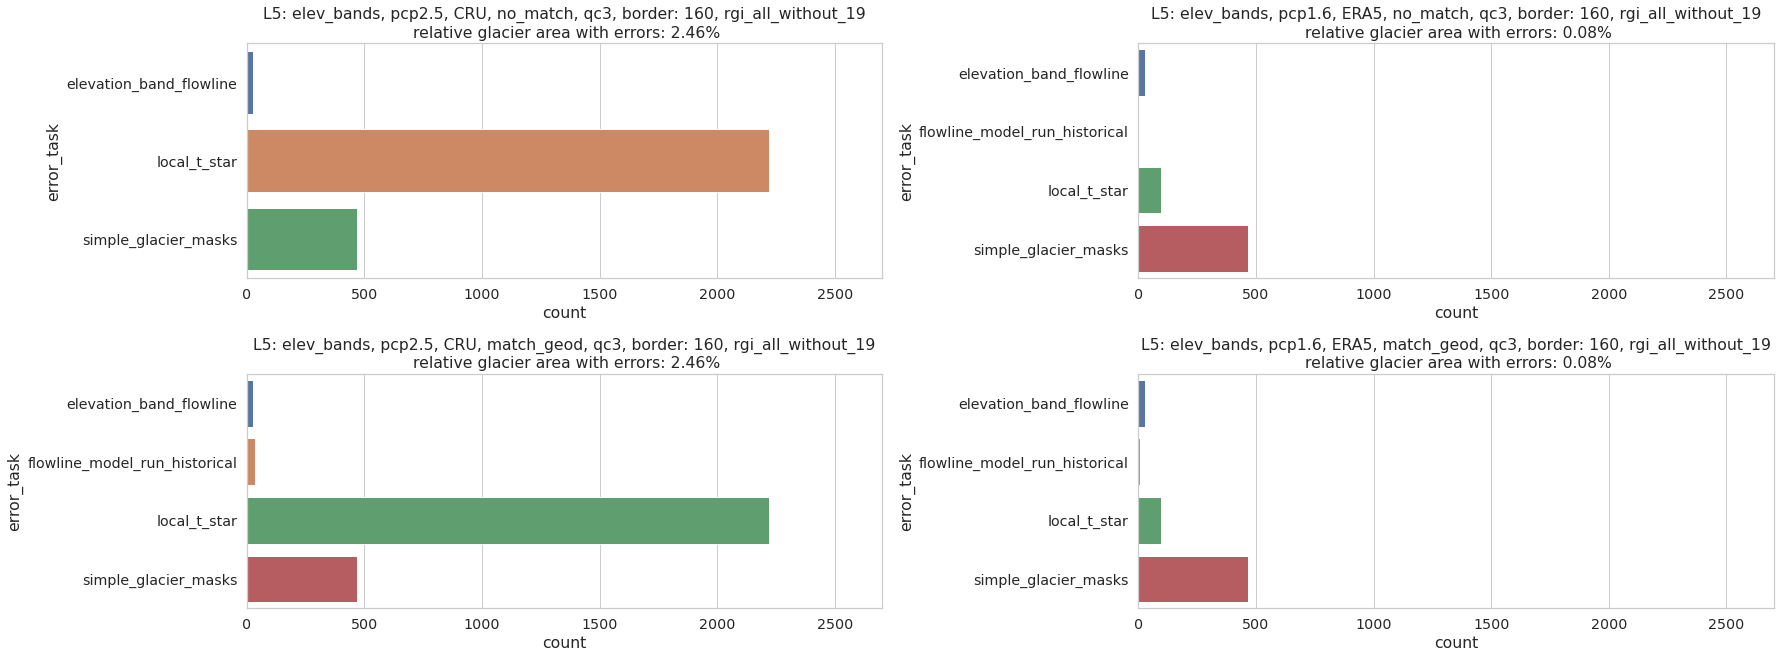

In [40]:
exp = 'elev_bands'
qc = 'qc3'
pcps = ['pcp2.5', 'pcp1.6']
clims = ['CRU', 'ERA5']
# when we compare between ERA5 and CRU, we have to omit region 19 because CRU has no climate date for RGI region 19!
rgi_reg = 'all_without_19'
missing = []
# different match options only available for elev_bands

plt.figure(figsize=(25,18))
n = 1
for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
    for pcp, clim in zip(pcps, clims):
        plt.subplot(4,2,n)
        n += 1
        try:
            dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area,
                                                              level=level,exp=exp, pcp =pcp, clim=clim, 
                                                              qc=qc,border=border, match=match,
                                                              rgi_reg = rgi_reg,
                                                              subplot=True, xlim=2700)
        except:
            missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}')
            plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}')
plt.tight_layout()


**Let's repeat the same for the centerlines:**
- so far, we can only look at no_match 
- match_geod would also work with centerlines but there are no preprocessed directories for that
- match_geod_pergla does NOT work with centerlines!!! 

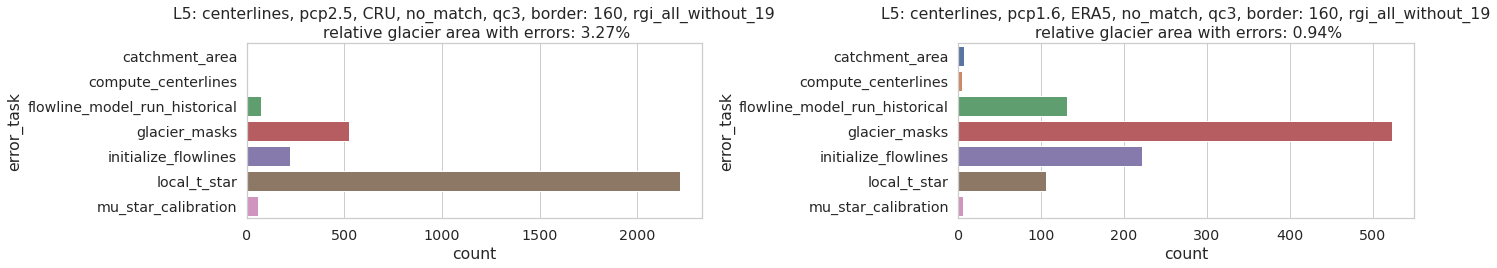

In [41]:
exp = 'centerlines'
match = 'no_match'
rgi_reg = 'all_without_19'
plt.figure(figsize=(20,4))
n = 1
for pcp, clim in zip(pcps, clims):
    plt.subplot(1,2,n)
    n += 1
    try:
        dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area,
                                                          level=level,exp=exp, pcp =pcp, clim=clim, 
                                                          qc=qc,border=border, match=match,
                                                          rgi_reg=rgi_reg, subplot=True)
    except:
        missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}')
        plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}')
plt.tight_layout()

Let's have a quick look at the largest failing glaciers and their errors!

In [42]:
dfserr[f'L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-17.15808       721.950  local_t_star   
RGI60-17.15897       428.505  local_t_star   
RGI60-05.10735       392.607  local_t_star   
RGI60-05.10634       388.067  local_t_star   
RGI60-05.10617       373.290  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-17.15808  MassBalanceCalibrationError: RGI60-17.15808: mu* out of specified bounds: 3.30  
RGI60-17.15897  MassBalanceCalibrationError: RGI60-17.15897: mu* out of specified bounds: 2.21  
RGI60-05.10735  MassBalanceCalibrationError: RGI60-05.10735: mu* out of specified bounds: 0.91  
RGI60-05.10634  MassBalanceCalibrationError: RGI60-05.10634: mu* out of specified bounds: 2.07  
RGI60-05.10617  MassBalanceCalibrationError: RGI60-05.10617: mu* out of specified bounds: 3.45

In [43]:
dfserr[f'L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19'].head()

rgi_area_km2            error_task  \
rgi_id                                               
RGI60-10.00002        48.144  simple_glacier_masks   
RGI60-15.10055        26.727          local_t_star   
RGI60-15.01996        16.642          local_t_star   
RGI60-15.04835        15.377          local_t_star   
RGI60-10.00006        12.966  simple_glacier_masks   

                                                                                         error_msg  
rgi_id                                                                                              
RGI60-10.00002                                 GeometryError: RGI60-10.00002 is a nominal glacier.  
RGI60-15.10055  MassBalanceCalibrationError: RGI60-15.10055: mu* out of specified bounds: 10290.99  
RGI60-15.01996  MassBalanceCalibrationError: RGI60-15.01996: mu* out of specified bounds: 19149.61  
RGI60-15.04835  MassBalanceCalibrationError: RGI60-15.04835: mu* out of specified bounds: 12269.57  
RGI60-10.00006                                 GeometryError: RGI60-10.00006 is a nominal glacier.

- for a better comparison we only look at the relative failing glacier area difference between the experiments

In [44]:
# get only the errors from preprocessing level L5
pd_rel_error_area_L5 = pd_rel_error_area[(pd_rel_error_area.level == 'L5') & (pd_rel_error_area.rgi_reg =='all_without_19')]
pd_rel_error_area_L5

rel_error_area_in_percent  \
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19                     2.460572   
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19                    0.081001   
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19                   2.460745   
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19                  0.081299   
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19                    3.273621   
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19                   0.936732   

                                                                 level  \
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19       L5   
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19      L5   
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19     L5   
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19    L5   
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19      L5   
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19     L5   

                                                                          exp  \
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19      elev_bands   
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19     elev_bands   
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19    elev_bands   
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19   elev_bands   
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19    centerlines   
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19   centerlines   

                                                                     clim_pcp  \
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19      CRU_pcp2.5   
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19    ERA5_pcp1.6   
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19    CRU_pcp2.5   
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19  ERA5_pcp1.6   
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19     CRU_pcp2.5   
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19   ERA5_pcp1.6   

                                                                       match  \
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19       no_match   
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19      no_match   
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19   match_geod   
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19  match_geod   
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19      no_match   
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19     no_match   

                                                                   qc border  \
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19     qc3    160   
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19    qc3    160   
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19   qc3    160   
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19  qc3    160   
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19    qc3    160   
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19   qc3    160   

                                                                         rgi_reg  
L5_elev_bands_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19     all_without_19  
L5_elev_bands_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19    all_without_19  
L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_all_without_19   all_without_19  
L5_elev_bands_pcp1.6_ERA5_match_geod_qc3_b160_rgi_all_without_19  all_without_19  
L5_centerlines_pcp2.5_CRU_no_match_qc3_b160_rgi_all_without_19    all_without_19  
L5_centerlines_pcp1.6_ERA5_no_match_qc3_b160_rgi_all_without_19   all_without_19

Let's plot this in a nicer way!

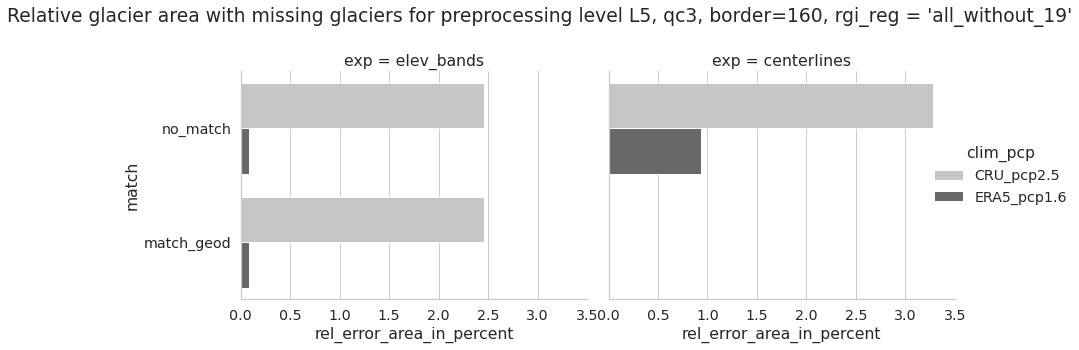

In [45]:
sns.catplot(y="match", x="rel_error_area_in_percent", data=pd_rel_error_area_L5,
            hue='clim_pcp', orient='h', col='exp',
           kind='bar', palette='Greys') #['Black', 'Grey'])
plt.xlim([0,3.5])
plt.suptitle("Relative glacier area with missing glaciers for preprocessing level L5, qc3, border=160, rgi_reg = 'all_without_19'")
plt.tight_layout()

- there is a short description of all findings [right here](#id-total-error-area-summary)!

### Let's now repeat the same for preprocesed directories without climate quality check and correction (qc0)
- for `match_geod_pergla` and for `match_geod_pergla_massredis`, only qc0 is used! 


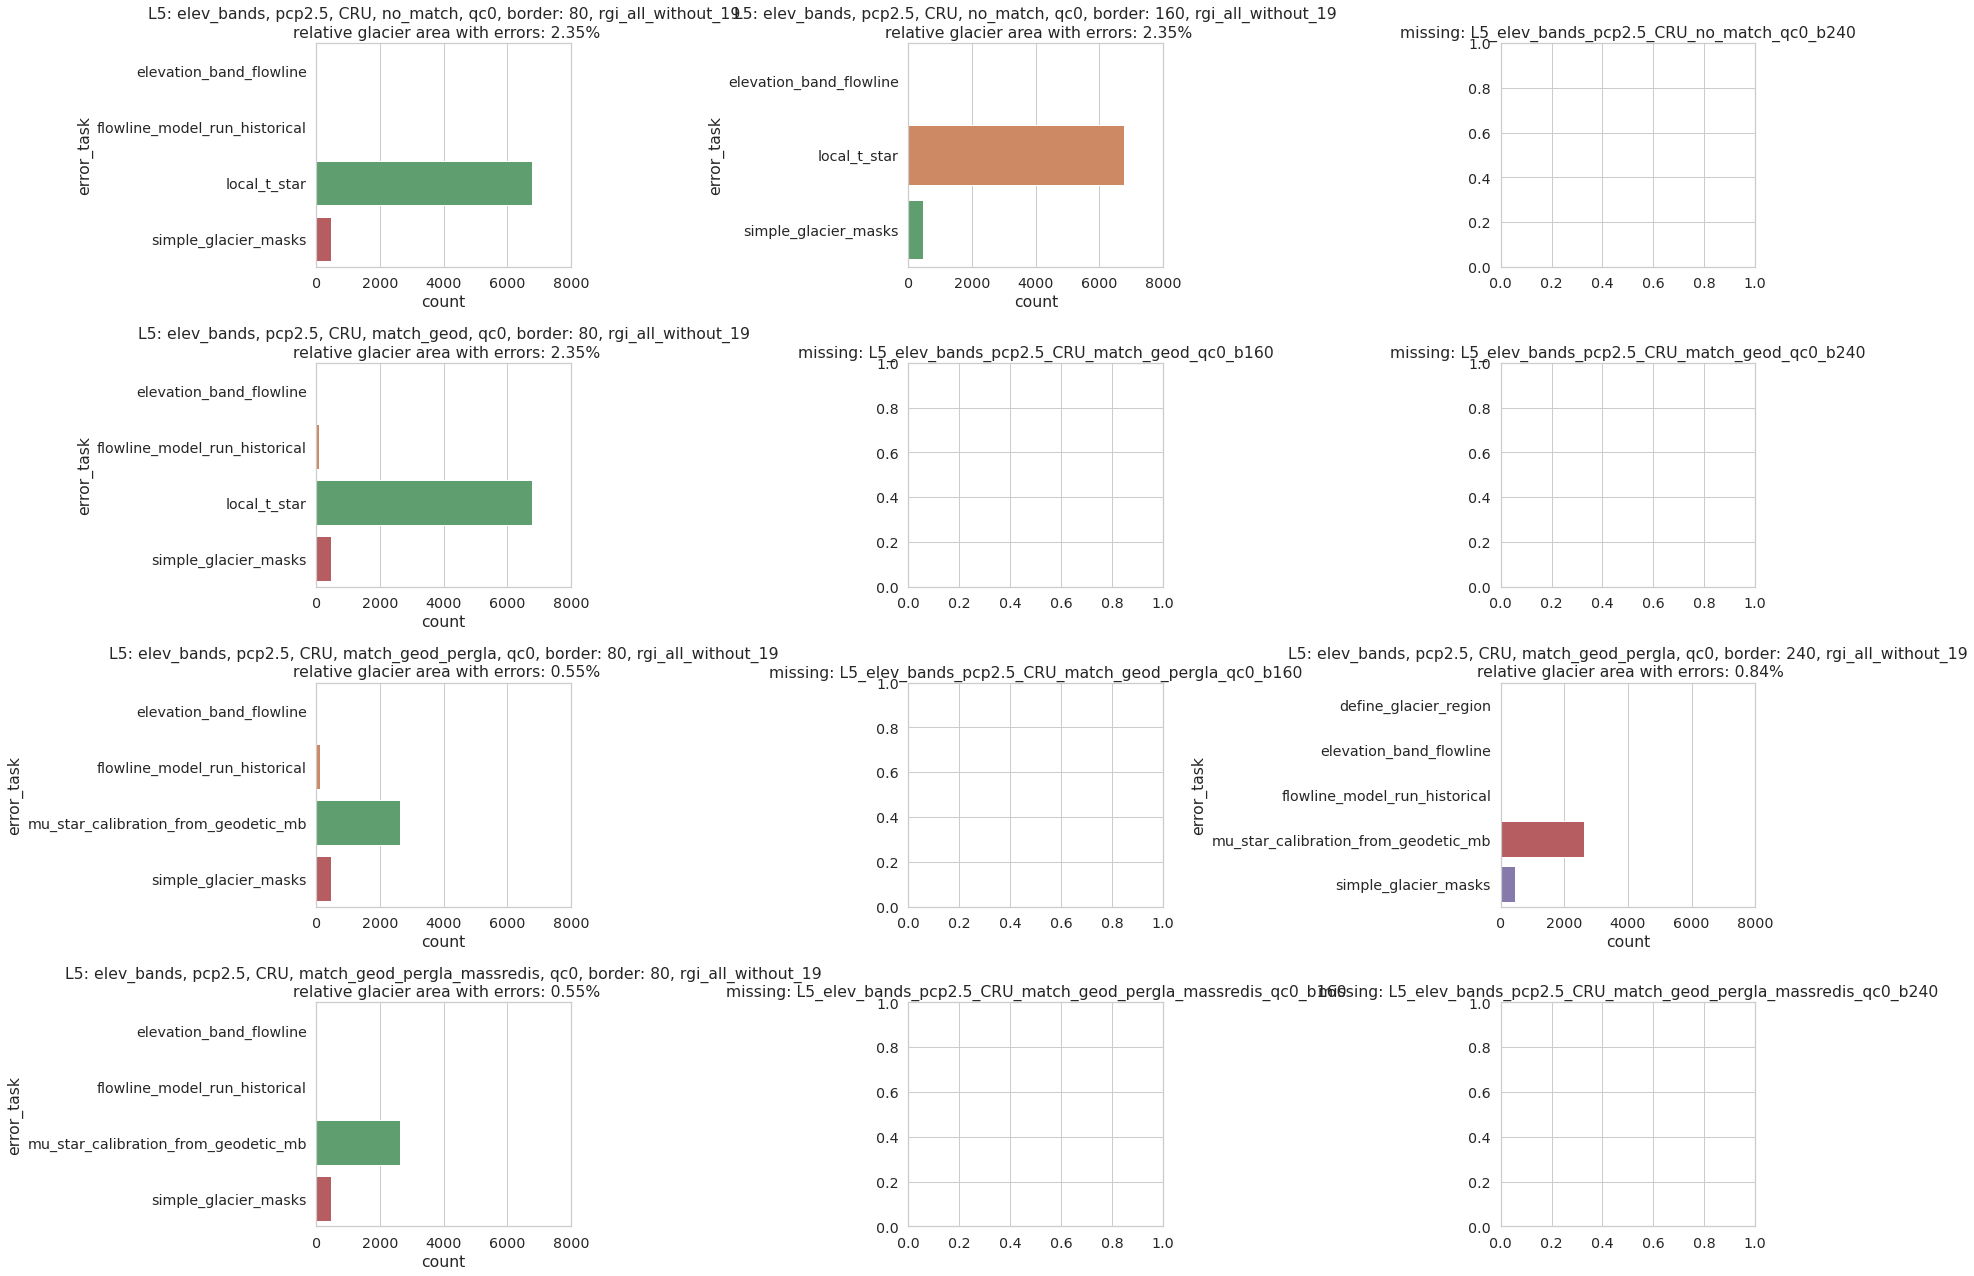

In [46]:
qc = 'qc0'
level = 'L5'
pcp = 'pcp2.5' 
clim = 'CRU' #, 'ERA5']
exp = 'elev_bands' #, 'centerlines']:
rgi_reg = 'all_without_19'

missing = []
# different match options only available for elev_bands

plt.figure(figsize=(25,18))
n = 1
for match in ['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
    for border in [80, 160, 240]:
        plt.subplot(4,3,n)
        n += 1
        try:
            # todo remove this, when all preprocessed gdirs are inside of main oggm 
            if 'match_geod_pergla' in match:
                path = '/home/www/oggm/gdirs/oggm_v1.6/'
            else:
                path = '/home/www/oggm/gdirs/oggm_v1.4/'
            dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area,
                                                              level=level,exp=exp, pcp =pcp, clim=clim, 
                                                              qc=qc,border=border, match=match,path=path,
                                                              rgi_reg=rgi_reg, subplot=True, xlim=8000)

        except:
            missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}')
            plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}')
plt.tight_layout()




- a larger domain (border = 240 instead of border=80), does not always result in smaller amount of errors. 
    - a https error coming from the DEM being too large could occur if the border is set too large! (see largest errors for b240 below). This is an error that could be solved, but only occurs rarely and is not important on global scales where the border is set to 80 or 160 anyways!

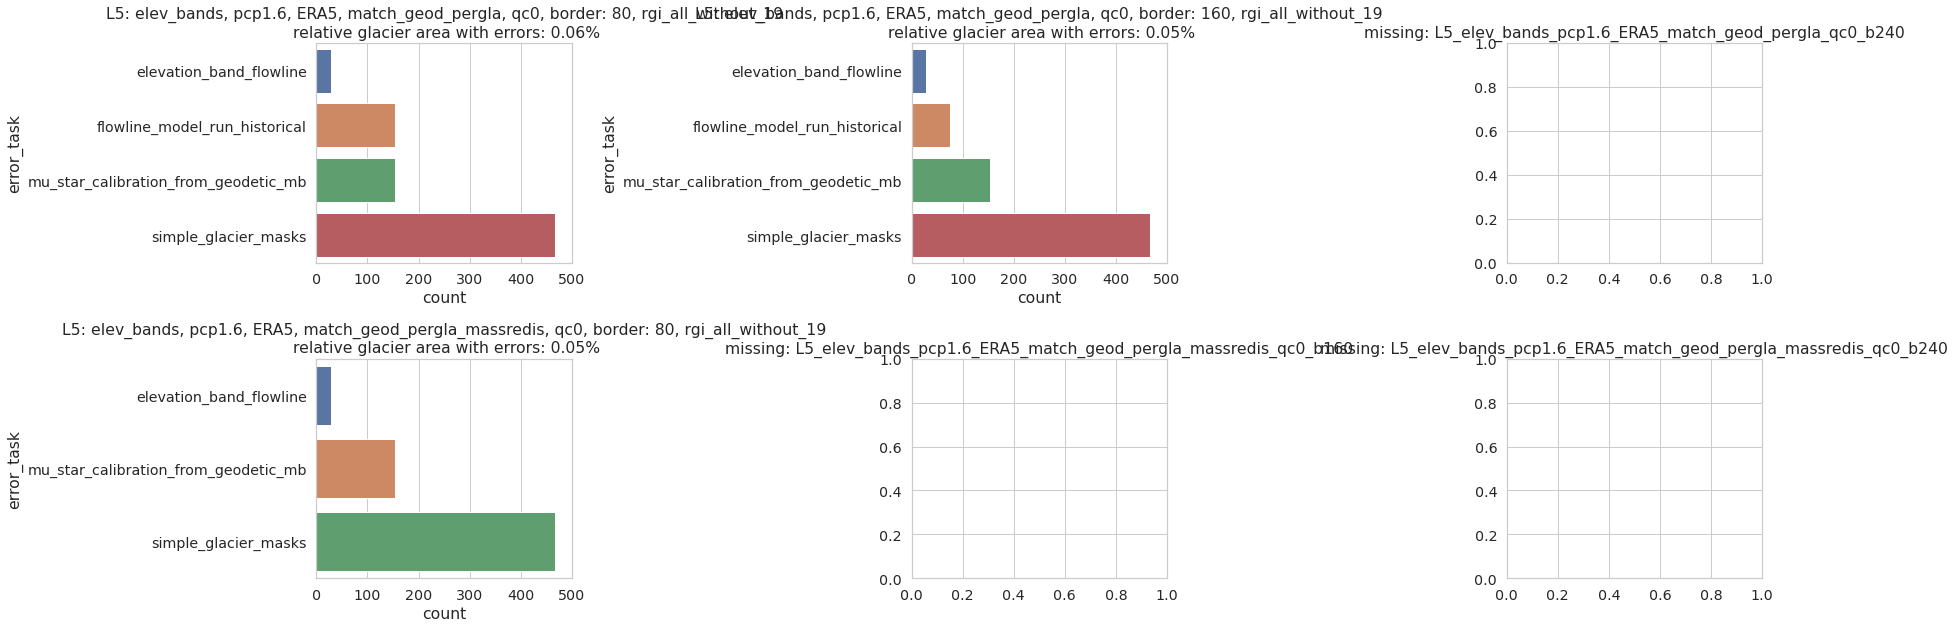

In [47]:
# Let's also plot this for ERA5!!!
qc = 'qc0'
level = 'L5'
pcp = 'pcp1.6' 
clim = 'ERA5' #, 'ERA5']
exp = 'elev_bands' #, 'centerlines']:
rgi_reg = 'all_without_19'

missing = []
# different match options only available for elev_bands

plt.figure(figsize=(25,9))
n = 1
#  no qc0 for ERA5 for the other match options at the moment
for match in ['match_geod_pergla', 'match_geod_pergla_massredis']:  
    for border in [80, 160, 240]:
        plt.subplot(2,3,n)
        n += 1
        try:
            # todo remove this, when all preprocessed gdirs are inside of same oggm folder 
            if 'match_geod_pergla' in match:
                path = '/home/www/oggm/gdirs/oggm_v1.6/'
            else:
                path = '/home/www/oggm/gdirs/oggm_v1.4/'
            dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr, pd_rel_error_area=pd_rel_error_area,
                                                              level=level,exp=exp, pcp =pcp, clim=clim, 
                                                              qc=qc,border=border, match=match,path=path,
                                                              rgi_reg=rgi_reg, subplot=True, xlim=500)

        except:
            missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}')
            plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}')
plt.tight_layout()


In [48]:
# Let's get all level 5 statistics (for both, qc0 and qc3!)
pd_rel_error_area_L5 = pd_rel_error_area[(pd_rel_error_area.level == 'L5') & (pd_rel_error_area.rgi_reg =='all_without_19')]
# we only use border = 80 for qc0 as this is the option where most preprocessed directories are available
condi1 = ((pd_rel_error_area_L5.border == 80) & (pd_rel_error_area_L5.qc=='qc0'))
# we only use border = 160 for qc3 as this is the option where most preprocessed directories are available
condi2 = ((pd_rel_error_area_L5.border == 160) & (pd_rel_error_area_L5.qc=='qc3'))
condi3 = ((pd_rel_error_area_L5.border == 160) & (pd_rel_error_area_L5.qc=='qc0') & (pd_rel_error_area_L5.match == 'match_geod_pergla'))

pd_rel_error_area_L5 = pd_rel_error_area_L5[condi1 | condi2 | condi3]

<a id='id-total-error-area-summary'></a>

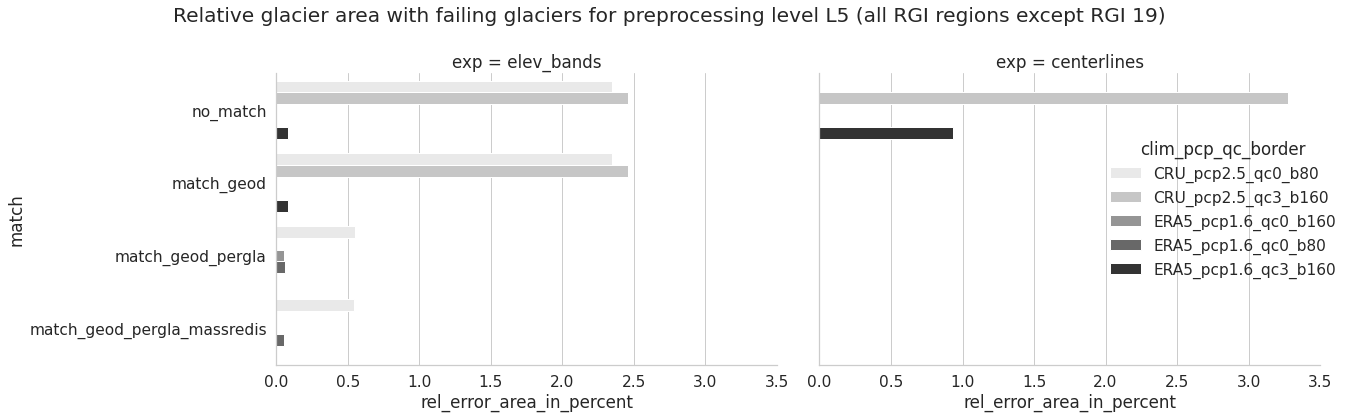

In [49]:
sns.set(font_scale = 1.4)
sns.set_style('whitegrid')
pd_rel_error_area_L5['clim_pcp_qc_border'] = np.NaN
_hue = pd_rel_error_area_L5['clim_pcp'].values+'_'+pd_rel_error_area_L5['qc'].values+'_b'+ pd_rel_error_area_L5['border'].values.astype(str)
pd_rel_error_area_L5['clim_pcp_qc_border'] = _hue
pd_rel_error_area_L5 = pd_rel_error_area_L5.sort_values('clim_pcp_qc_border')

sns.catplot(y="match", x="rel_error_area_in_percent", data=pd_rel_error_area_L5,
            hue='clim_pcp_qc_border', orient='h', col='exp',
           kind='bar', palette='Greys',
           height=6, aspect=1.3)
plt.suptitle("Relative glacier area with failing glaciers for preprocessing level L5 (all RGI regions except RGI 19)")
ax = plt.gca()
plt.xlim([0,3.5])
plt.tight_layout();
plt.savefig('relative_failing_glacier_area.png')

By plotting the different error types and the relative failing glacier area, we can conclude:
- with CRU much more glaciers and glacier area fail than with ERA5
    - for CRU, the main errors are coming from local_t_star or mu_star_calibration_from_geodetic_mb, hence from the MB calibration
    - for ERA5, more errors come from (simple_)glacier_masks or elevation_band_flowline (which are those errors that occur already in pre-processing Level 2)
- using centerlines results in more errors than using elevation band flowlines
- from the different match options to calibrate the mass-balance, 'no_match' and 'match_geod' result in more errors than 'match_geod_pergla', specifically when using CRU
- 'match_geod_pergla_massredis' has around the same amount of errors / relative failing glacier area as 'match_geod_pergla', except for RGI region 19 where using a mass redistribution instead of the SIA results in a 4\*larger failing glacier area (see more [here](#id-rgi-19))
- not applying any quality checks and climate corrections results in slightly less (for no_match or match_geod):
    - For all RGI regions except RGI region 05 (and RGI 19 because this is not available for CRU), qc0 results, however, in equal or more errors.
    - The large failing glacier area in RGI region 05 (i.e. the largest RGI glacier region) when using qc3 results in the global estimate that qc0 has in total less failing glacier area than qc3.
    - note that for match_geod_pergla, an internal quality check and climate correction is always done if the mu_star is not in the specified bound (20, 600). Therefore, no qc3 exists for them.
    - (see more [here](#id-rgi-diff))

### Method to get those glaciers that work for all preprocessed glacier directories? This is important when later trying to compare volume estimates between each other!

In [50]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']
# we do not model RGI region 19 because we want to compare it to CRU!!! 
pd_geodetic = pd_geodetic[pd_geodetic.reg != 19]

total_area = pd_geodetic.area.sum()
total_counts = len(pd_geodetic)
# pd_geodetic.area
pd_working = pd.DataFrame(index = pd_geodetic.index,
                        columns=dfserr.keys())
# we will set those that are not running afterwards to np.NaN value
pd_working.loc[pd_geodetic.index] = True
pd_working['area'] = pd_geodetic.area
pd_working['all_running_rgis'] = np.NaN
pd_working['rgi_reg'] = pd_geodetic.reg


In [51]:
for key in dfserr.keys():
    if 'rgi_all_without_19' in key: 
        failing_rgis = dfserr[key].index.values

        # pd_error[cmip6_output_type] = False
        # set those glaciers that did not work to np.NaN
        pd_working.loc[failing_rgis,key] = np.NaN
        
        # check if it worked
        assert len(failing_rgis) == len(pd_working.loc[pd_working[key].isna()])
    else:
        pd_working = pd_working.drop(columns=key)
        pass


In [52]:
all_running_rgis = pd_working[pd_working.columns[:-3]].dropna().index

In [53]:
pd_working.loc[all_running_rgis, 'all_running_rgis'] = True


In [54]:
all_running_rel = len(all_running_rgis)*100/len(pd_geodetic)
all_running_rel_area = pd_working.loc[all_running_rgis].area.sum()*100/pd_working.area.sum()

print(f'Amount of glaciers (without Antarctica RGI region 19) that run without glaciers for all compared preprocessed gdirs: {len(all_running_rgis)}')
print(f'Relative percentage of glacier amount where all analysed L5 preprocessed gdirs do not fail: {all_running_rel:0.2f}%')
print(f'Relative percentage of glacier area where all analysed L5 preprocessed gdirs do not fail: {all_running_rel_area:0.2f}%')

Amount of glaciers (without Antarctica RGI region 19) that run without glaciers for all compared preprocessed gdirs: 201973
Relative percentage of glacier amount where all analysed L5 preprocessed gdirs do not fail: 94.91%
Relative percentage of glacier area where all analysed L5 preprocessed gdirs do not fail: 94.27%


In [55]:
pd_rel_error_area_L5.to_csv('rel_error_area_statistics_for_prepro_level5_gdirs.csv')
pd_working.to_csv('working_rgis_for_prepro_level5_gdirs.csv')

We will use this working glacier list in [this notebook which analyses the volume, mass change and specific mass balance differences between the preprocessed gdir options](https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~lschuster/error_analysis/working_glacier_gdirs_comparison.ipynb?flush_cache=true). Feel free to check it out afterwards!

## Regional RGI error check for the different options:

In [127]:
level = 'L5'
exp = 'elev_bands' #, 'centerlines']:

dfserr_reg = {}
pd_rel_error_area_reg = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp',
                                              'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

missing = []
# different match options only available for elev_bands
for pcp, clim in zip(pcps, clims):
    for match in ['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for qc in ['qc0', 'qc3']:
            for rgi_reg in np.arange(0,21,1):
                if 0<rgi_reg <10:
                    rgi_reg = f'0{rgi_reg}'
                elif rgi_reg == 0:
                    rgi_reg = 'all_without_19'
                elif rgi_reg == 20:
                    rgi_reg = 'all'
                else:
                    rgi_reg = str(rgi_reg)
                if qc == 'qc0':
                    border = 80
                else:
                    border = 160
                try:
                    # todo remove this, when all preprocessed gdirs are inside of main oggm 
                    if 'match_geod_pergla' in match:
                        path = '/home/www/oggm/gdirs/oggm_v1.6/'
                    else:
                        path = '/home/www/oggm/gdirs/oggm_v1.4/'
                    dfserr_reg, pd_rel_error_area_reg = error_analysis_w_plot(dfserr=dfserr_reg, pd_rel_error_area=pd_rel_error_area_reg,
                                                                      level=level,exp=exp, pcp =pcp, clim=clim, 
                                                                      qc=qc,border=border, match=match, path=path,
                                                                      rgi_reg=rgi_reg, plot = False)

                except:
                    missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}_b{border}_rgi_{rgi_reg}')


<a id='id-rgi-diff'></a>

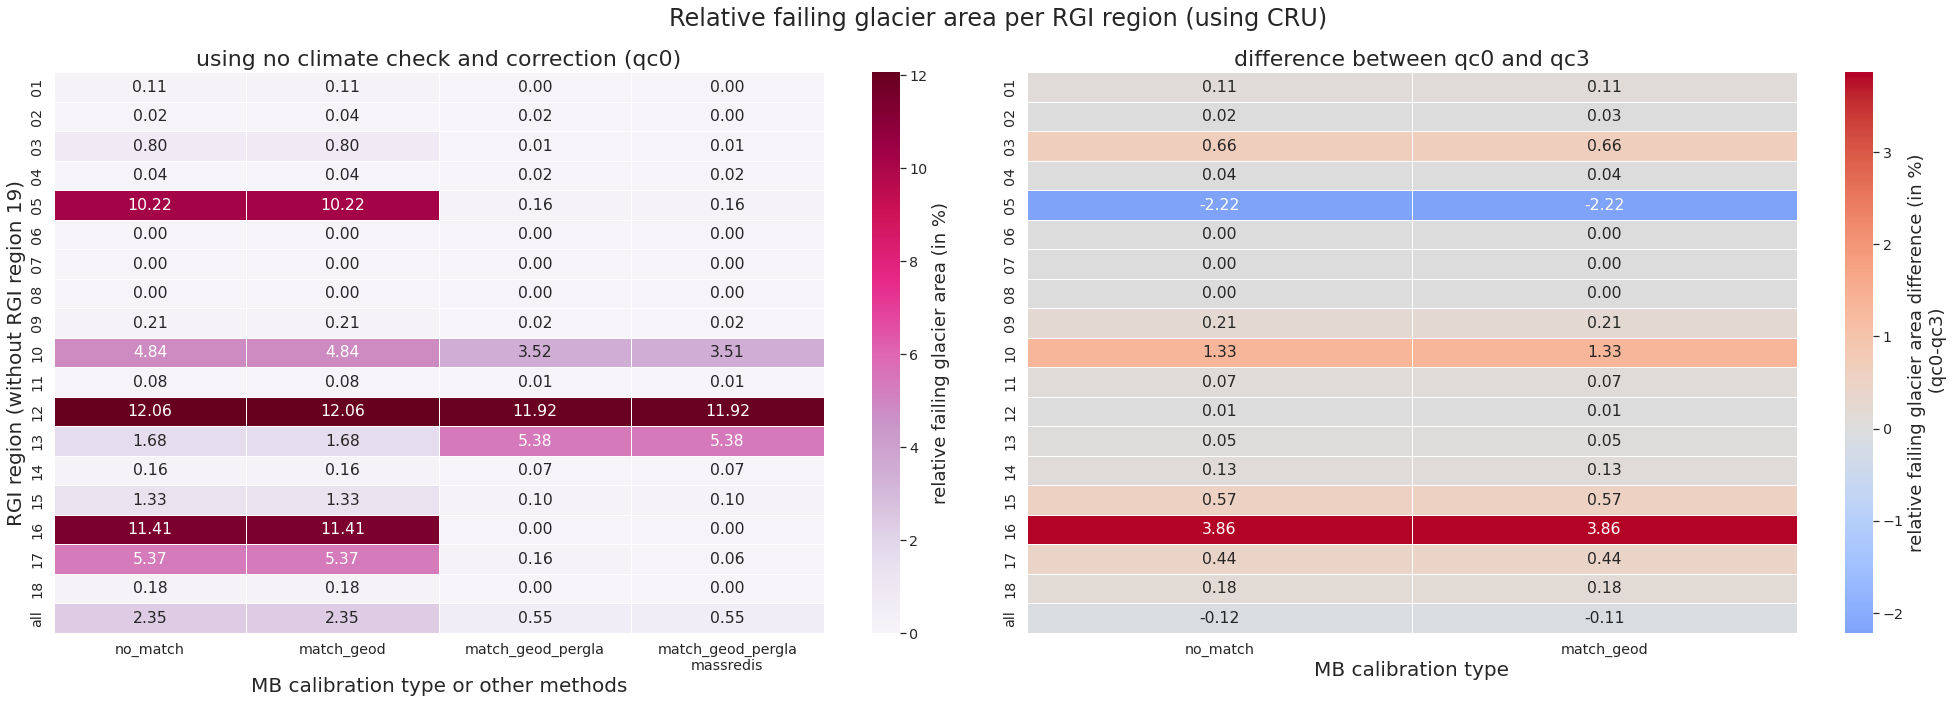

In [108]:
clim = 'CRU'
pcp = '2.5'
pd_rel_error_area_reg_clim = pd_rel_error_area_reg.loc[pd_rel_error_area_reg.clim_pcp == f'{clim}_pcp{pcp}']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_clim[pd_rel_error_area_reg_clim.qc == 'qc0']
pd_rel_error_area_reg_qc0.index = pd_rel_error_area_reg_qc0['rgi_reg']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['rel_error_area_in_percent','match']]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.pivot(columns=['match'])
pd_rel_error_area_reg_qc0.columns = pd_rel_error_area_reg_qc0.columns.droplevel(0)
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.astype("float32")
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.rename({'all_without_19':'all'})
pd_rel_error_area_reg_qc0= pd_rel_error_area_reg_qc0.rename(columns={'match_geod_pergla_massredis': 'match_geod_pergla\nmassredis'})

pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_clim[pd_rel_error_area_reg_clim.qc == 'qc3']
pd_rel_error_area_reg_qc3.index = pd_rel_error_area_reg_qc3['rgi_reg']
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3[['rel_error_area_in_percent','match']]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.pivot(columns=['match'])
pd_rel_error_area_reg_qc3.columns = pd_rel_error_area_reg_qc3.columns.droplevel(0)
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.astype("float32")
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3[['no_match', 'match_geod']] #, 'match_geod_pergla']]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.rename({'all_without_19':'all'})
sns.set(font_scale = 1.3)
plt.figure(figsize=(28,10))
plt.suptitle(f'Relative failing glacier area per RGI region (using {clim})', fontsize=24)
plt.subplot(121)
plt.title('using no climate check and correction (qc0)', fontsize=22)
sns.heatmap(pd_rel_error_area_reg_qc0,
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier area (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region (without RGI region 19)', fontsize=20);
ax.set_xlabel('MB calibration type or other methods', fontsize=20)
plt.subplot(122)
plt.title('difference between qc0 and qc3', fontsize=22)

sns.heatmap(pd_rel_error_area_reg_qc0.drop(columns=['match_geod_pergla','match_geod_pergla\nmassredis']) - pd_rel_error_area_reg_qc3,
            linewidths=.5, cmap='coolwarm', 
            cbar_kws={'label':'relative failing glacier area difference (in %)\n (qc0-qc3)'},
           annot=True,center=0, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('');
ax.set_xlabel('MB calibration type', fontsize=20)

plt.tight_layout()

- `no_match` and `match_geod` have almost the same amount of relative failing glacier area
- with `qc0`, most relative glacier area fails in:
    - RGI region 5, 16, 17, 10 (descending order) with more MB calibration errors if using the no_match or match_geod options!
    - RGI region 12 mostly from missing outlines of nominal glaciers
    - RGI region 13 if using the match_geod_pergla method (no mu* could be found even when correcting the climate, which happens in that case for both qc0 and qc3!)
- differences between qc0 and qc3:
    - only in RGI region 5 (Greenland) more glaciers fail when using qc3, but RGI region 5 is the RGI region with the largest glacier area!!!
    - for all other RGI regions, more glaciers fail with qc0 (specifically for RGI region 16 & 10, where there are more MB calibration errors for qc0 than for qc3)

**RGI region 13 check**

- What is so specific in RGI region 13 that **match_geod_pergla** works less good using CRU specifically (more than twice as much errors and 3\*times as much area, see below) than when using the direct reference glacier calibration data (no_match)?
    - The problem is actually that precipitation is so low for these glaciers, that it can not reproduce the observed geodetic **positive** specific mass balance.

In [148]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].head()

rgi_area_km2                            error_task  \
rgi_id                                                               
RGI60-13.37825        51.478  mu_star_calibration_from_geodetic_mb   
RGI60-13.54059        42.521  mu_star_calibration_from_geodetic_mb   
RGI60-13.37587        32.259  mu_star_calibration_from_geodetic_mb   
RGI60-13.53668        29.870  mu_star_calibration_from_geodetic_mb   
RGI60-13.38833        27.602  mu_star_calibration_from_geodetic_mb   

                                                                                                                                     error_msg  
rgi_id                                                                                                                                          
RGI60-13.37825  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.54059  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.37587  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.53668  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.38833  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.

Text(0.5, 0, 'dmdtda')

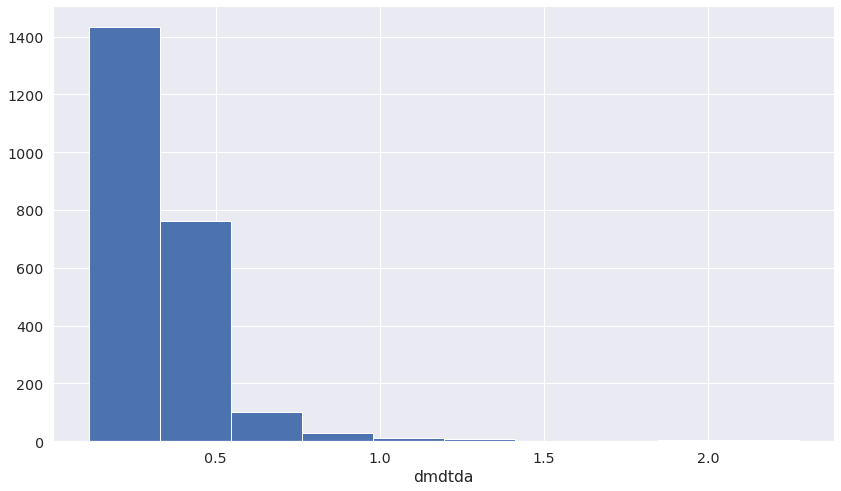

In [67]:
plt.hist(pd_geodetic.loc[dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].index].dmdtda)
plt.xlabel('dmdtda')


- all failing glaciers have a positive mass balance. This is the reason that glaciers are failing. 
    - maybe a larger precipitation factor for CRU would be necessary in this region specifically !!!
    - If we use instead ERA5 (see below), much less glaciers fail in this region!

In [68]:
print('with match_geod_pergla:')
print(f"amount of glaciers failing in RGI 13: {len(dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'])}")
print(f"failing glacier area in RGI 13:  {dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].rgi_area_km2.sum():0.1f} km2")

with match_geod_pergla:
amount of glaciers failing in RGI 13: 2357
failing glacier area in RGI 13:  2653.1 km2


In [69]:
# what are the glaciers failing for no match???
dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-13.38733        30.849  local_t_star   
RGI60-13.38742        20.997  local_t_star   
RGI60-13.38768        18.447  local_t_star   
RGI60-13.38924        13.702  local_t_star   
RGI60-13.37368        13.572  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-13.38733  MassBalanceCalibrationError: RGI60-13.38733: mu* out of specified bounds: 3.57  
RGI60-13.38742  MassBalanceCalibrationError: RGI60-13.38742: mu* out of specified bounds: 4.26  
RGI60-13.38768  MassBalanceCalibrationError: RGI60-13.38768: mu* out of specified bounds: 4.19  
RGI60-13.38924  MassBalanceCalibrationError: RGI60-13.38924: mu* out of specified bounds: 4.51  
RGI60-13.37368  MassBalanceCalibrationError: RGI60-13.37368: mu* out of specified bounds: 2.67

In [70]:
print('with no_match:')
print(f"amount of glaciers failing in RGI 13: {len(dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'])}")
print(f"failing glacier area in RGI 13:  {dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'].rgi_area_km2.sum():0.1f} km2")

with no_match:
amount of glaciers failing in RGI 13: 1015
failing glacier area in RGI 13:  826.3 km2


Let's get a list of only those that fail for match_geod_pergla, but not for no_match!

In [71]:
rgi_fail_no_match = dfserr_reg['L5_elev_bands_pcp2.5_CRU_no_match_qc0_b80_rgi_13'].index
rgi_fail_match_geod_pergla = dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13'].index.values
rgi_fail_both = rgi_fail_no_match & rgi_fail_match_geod_pergla
pd_failing_rgi13_pergla = dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_pergla_qc0_b80_rgi_13']

/tmp/ipykernel_1980629/3363420844.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  rgi_fail_both = rgi_fail_no_match & rgi_fail_match_geod_pergla


In [72]:
pd_failing_rgi13_pergla.drop(rgi_fail_both)

rgi_area_km2                            error_task  \
rgi_id                                                               
RGI60-13.37825        51.478  mu_star_calibration_from_geodetic_mb   
RGI60-13.54059        42.521  mu_star_calibration_from_geodetic_mb   
RGI60-13.37587        32.259  mu_star_calibration_from_geodetic_mb   
RGI60-13.53668        29.870  mu_star_calibration_from_geodetic_mb   
RGI60-13.38833        27.602  mu_star_calibration_from_geodetic_mb   
...                      ...                                   ...   
RGI60-13.52437         0.015  mu_star_calibration_from_geodetic_mb   
RGI60-13.51818         0.015  mu_star_calibration_from_geodetic_mb   
RGI60-13.52388         0.013  mu_star_calibration_from_geodetic_mb   
RGI60-13.52461         0.012  mu_star_calibration_from_geodetic_mb   
RGI60-13.52143         0.012  mu_star_calibration_from_geodetic_mb   

                                                                                                                                     error_msg  
rgi_id                                                                                                                                          
RGI60-13.37825  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.54059  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.37587  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.53668  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.38833  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
...                                                                                                                                        ...  
RGI60-13.52437  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.51818  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.52388  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.52461  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.52143  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  

[1860 rows x 3 columns]

It is not just one glacier that does not work with the match_geod_pergla method, but rather a lot of different mid-size glaciers. 

**RGI region 5 check**

In [73]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_05'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-05.10988       207.766  local_t_star   
RGI60-05.11001       182.955  local_t_star   
RGI60-05.10885       170.533  local_t_star   
RGI60-05.10615       167.934  local_t_star   
RGI60-05.11026       160.435  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-05.10988  MassBalanceCalibrationError: RGI60-05.10988: mu* out of specified bounds: 3.31  
RGI60-05.11001  MassBalanceCalibrationError: RGI60-05.11001: mu* out of specified bounds: 1.59  
RGI60-05.10885  MassBalanceCalibrationError: RGI60-05.10885: mu* out of specified bounds: 3.18  
RGI60-05.10615  MassBalanceCalibrationError: RGI60-05.10615: mu* out of specified bounds: 3.01  
RGI60-05.11026  MassBalanceCalibrationError: RGI60-05.11026: mu* out of specified bounds: 1.59

In [74]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_05'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-05.10735       392.607  local_t_star   
RGI60-05.10634       388.067  local_t_star   
RGI60-05.10617       373.290  local_t_star   
RGI60-05.10762       309.061  local_t_star   
RGI60-05.10988       207.766  local_t_star   

                                                                                     error_msg  
rgi_id                                                                                          
RGI60-05.10735  MassBalanceCalibrationError: RGI60-05.10735: mu* out of specified bounds: 0.91  
RGI60-05.10634  MassBalanceCalibrationError: RGI60-05.10634: mu* out of specified bounds: 2.07  
RGI60-05.10617  MassBalanceCalibrationError: RGI60-05.10617: mu* out of specified bounds: 3.45  
RGI60-05.10762  MassBalanceCalibrationError: RGI60-05.10762: mu* out of specified bounds: 1.34  
RGI60-05.10988  MassBalanceCalibrationError: RGI60-05.10988: mu* out of specified bounds: 1.25

In [75]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_05']['error_msg'].iloc[0]

'MassBalanceCalibrationError: RGI60-05.10735: mu* out of specified bounds: 0.91'

In [76]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_05'].rgi_area_km2.sum()

9165.776

In [77]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_05'].rgi_area_km2.sum()

11154.001

- around 20% more glacier area fails with qc3 in RGI reg 5 (with match_geod and CRU), because of bigger glaciers with MassBalanceCalibrationErrors!!!.

**RGI region 16 check**

In [78]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_16'].head()

rgi_area_km2    error_task  \
rgi_id                                       
RGI60-16.01443        10.263  local_t_star   
RGI60-16.01473         7.372  local_t_star   
RGI60-16.00410         6.440  local_t_star   
RGI60-16.01483         5.482  local_t_star   
RGI60-16.01394         5.454  local_t_star   

                                                                                          error_msg  
rgi_id                                                                                               
RGI60-16.01443       MassBalanceCalibrationError: RGI60-16.01443: mu* out of specified bounds: 4.91  
RGI60-16.01473   MassBalanceCalibrationError: RGI60-16.01473: mu* out of specified bounds: 71516.08  
RGI60-16.00410       MassBalanceCalibrationError: RGI60-16.00410: mu* out of specified bounds: 0.84  
RGI60-16.01483  MassBalanceCalibrationError: RGI60-16.01483: mu* out of specified bounds: 109115.38  
RGI60-16.01394       MassBalanceCalibrationError: RGI60-16.01394: mu* out of specified bounds: 0.02

In [79]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc0_b80_rgi_16'].rgi_area_km2.sum()

267.156

In [80]:
dfserr_reg['L5_elev_bands_pcp2.5_CRU_match_geod_qc3_b160_rgi_16'].rgi_area_km2.sum()

176.732

- there is around 50% more failing glacier area for qc0 than for qc3 (with match_geod and CRU)

### Let's repeat this with ERA5

In [130]:
clim = 'ERA5'
pcp = '1.6'
pd_rel_error_area_reg_clim = pd_rel_error_area_reg.loc[pd_rel_error_area_reg.clim_pcp == f'{clim}_pcp{pcp}']

pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_clim[pd_rel_error_area_reg_clim.qc == 'qc0']

pd_rel_error_area_reg_qc0.index = pd_rel_error_area_reg_qc0['rgi_reg']
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['rel_error_area_in_percent','match']]
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.pivot(columns=['match'])
pd_rel_error_area_reg_qc0.columns = pd_rel_error_area_reg_qc0.columns.droplevel(0)
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0.astype("float32")
pd_rel_error_area_reg_qc0 = pd_rel_error_area_reg_qc0[['match_geod_pergla', 'match_geod_pergla_massredis']]
pd_rel_error_area_reg_qc0= pd_rel_error_area_reg_qc0.rename(columns={'match_geod_pergla_massredis':
                                                                     'match_geod_pergla\nmassredis'})
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_clim[pd_rel_error_area_reg_clim.qc == 'qc3']
pd_rel_error_area_reg_qc3.index = pd_rel_error_area_reg_qc3['rgi_reg']
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3[['rel_error_area_in_percent','match']]
pd_rel_error_area_reg_qc3 = pd_rel_error_area_reg_qc3.pivot(columns=['match'])
pd_rel_error_area_reg_qc3.columns = pd_rel_error_area_reg_qc3.columns.droplevel(0)

pd_rel_error_area_reg_best = pd.concat([pd_rel_error_area_reg_qc3, pd_rel_error_area_reg_qc0], axis=1)
pd_rel_error_area_reg_best = pd_rel_error_area_reg_best.rename(columns= {'no_match':'no_match\n(qc3)', 'match_geod' : 'match_geod\n(qc3)',
                                                               'match_geod_pergla': 'match_geod_pergla\n(qc0)',
                                                               'match_geod_pergla\nmassredis': 'match_geod_pergla\nmassredis (qc0)'})
pd_rel_error_area_reg_best = pd_rel_error_area_reg_best.astype("float32")

plt.figure(figsize=(14,10))
plt.suptitle(f'Relative failing glacier area per RGI region (using {clim})', fontsize=24)
#plt.subplot(121)
#plt.title('using no climate check and correction (qc0)', fontsize=22)
sns.heatmap(pd_rel_error_area_reg_best,
            linewidths=.5, cmap="PuRd", cbar_kws={'label':'relative failing glacier area (in %)'},
           annot=True, fmt=".2f")
ax = plt.gca()
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.set_ylabel('RGI region (without RGI region 19)', fontsize=20);
ax.set_xlabel('MB calibration type or other methods', fontsize=20)


Text(0.5, 46.159375, 'MB calibration type or other methods')

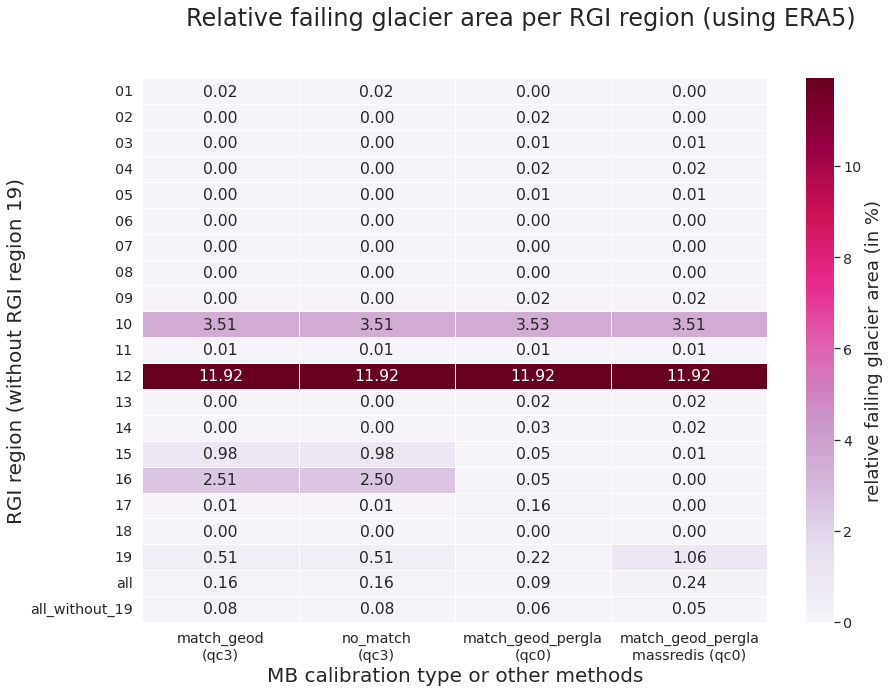

- ok, with ERA5, there are also some regions where we have more errors with match_geod_pergla and match_geod_pergla_massredis than with no_match (e.g. RGI 13,14), but it is never more than 0.03% of more failing glacier area
    - in RGI region 17, there is only for match_geod_pergla more failing glacier area and not for match_geod_pergla massredis (it is a flowline_model_run_historical error from level 5 and we would need a larger domain, e.g. border = 160 for that)!!!
- so maybe, at least for ERA5, it is not a big issue that the precipitation factor is too low to allow positive MB!!!

**Let's look again into RGI region 13 (but now for ERA5)**:

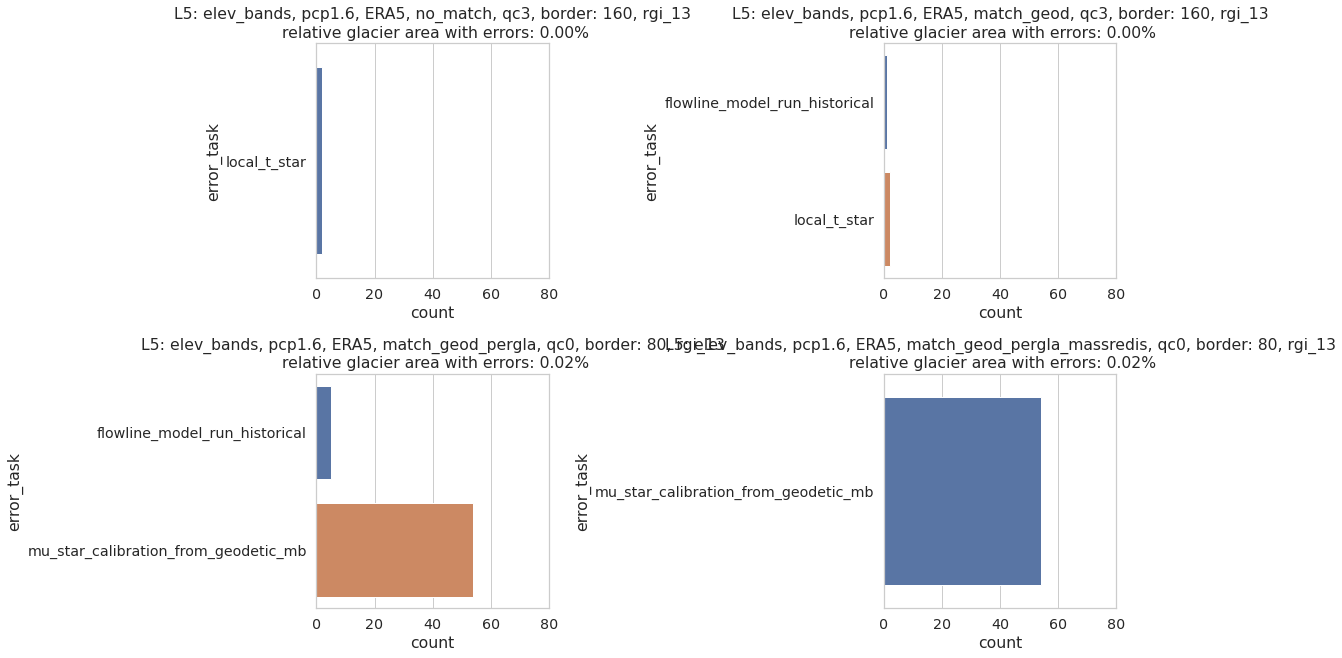

In [139]:
sns.set_style('whitegrid')

exp = 'elev_bands'
pcp = 'pcp1.6'
clim = 'ERA5'
# when we compare between ERA5 and CRU, we have to omit region 19 because CRU has no climate date for RGI region 19!
rgi_reg = '13'
missing = []
# different match options only available for elev_bands
dfserr_rgi19 = {}
pd_rel_error_area_rgi19 = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp',
                                              'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

plt.figure(figsize=(16,18))
n = 1
for match in ['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
    for exp in ['elev_bands']: #, 'centerlines']:
        if 'match_geod_pergla' in match:
            qc = 'qc0'
            border = 80
            # todo remove this, when all preprocessed gdirs are inside of main oggm 
            path = '/home/www/oggm/gdirs/oggm_v1.6/'
        else:
            qc = 'qc3'
            border = 160
            path = '/home/www/oggm/gdirs/oggm_v1.4/'

        plt.subplot(4,2,n)
        n += 1
        try:
            dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr_rgi19, pd_rel_error_area=pd_rel_error_area_rgi19,
                                                              level=level,exp=exp, pcp =pcp, clim=clim, 
                                                              qc=qc,border=border, match=match,
                                                              rgi_reg = rgi_reg, path = path,
                                                              subplot=True, xlim=80)
        except:
            missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}')
            plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}')
plt.tight_layout()


In [142]:
dfserr['L5_elev_bands_pcp1.6_ERA5_match_geod_pergla_qc0_b80_rgi_13'].iloc[:10]

rgi_area_km2                            error_task  \
rgi_id                                                               
RGI60-13.38409         1.037  mu_star_calibration_from_geodetic_mb   
RGI60-13.37824         1.029  mu_star_calibration_from_geodetic_mb   
RGI60-13.40589         0.840  mu_star_calibration_from_geodetic_mb   
RGI60-13.48588         0.522  mu_star_calibration_from_geodetic_mb   
RGI60-13.40780         0.366  mu_star_calibration_from_geodetic_mb   
RGI60-13.39450         0.311  mu_star_calibration_from_geodetic_mb   
RGI60-13.01152         0.286         flowline_model_run_historical   
RGI60-13.16826         0.283         flowline_model_run_historical   
RGI60-13.43348         0.274  mu_star_calibration_from_geodetic_mb   
RGI60-13.00998         0.270  mu_star_calibration_from_geodetic_mb   

                                                                                                                                     error_msg  
rgi_id                                                                                                                                          
RGI60-13.38409  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.37824  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.40589  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.48588  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.40780  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.39450  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.01152                                                               RuntimeError: Glacier exceeds domain boundaries, at year: 2008.25  
RGI60-13.16826                                                    RuntimeError: Glacier exceeds domain boundaries, at year: 2017.5833333333333  
RGI60-13.43348  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.  
RGI60-13.00998  MassBalanceCalibrationError: We could not find a way to correct the climate data and fit within the prescribed bounds for mu*.

## A closer look to RGI region 19 (only works with ERA5)

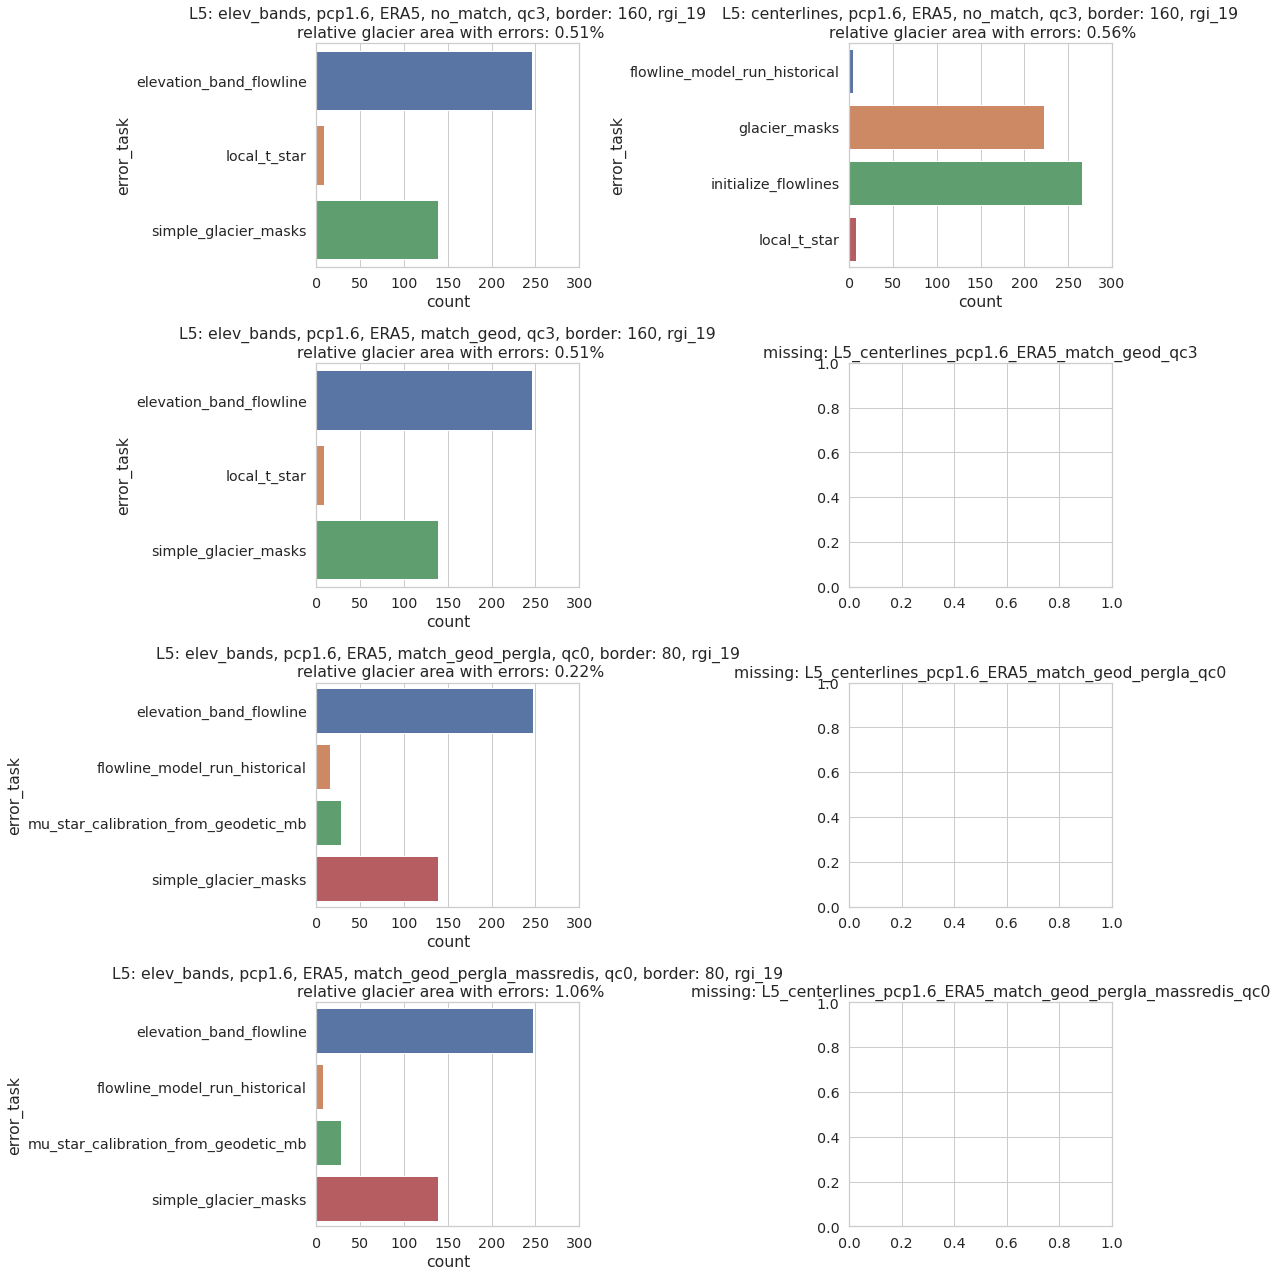

In [144]:
sns.set_style('whitegrid')

exp = 'elev_bands'
pcp = 'pcp1.6'
clim = 'ERA5'
# when we compare between ERA5 and CRU, we have to omit region 19 because CRU has no climate date for RGI region 19!
rgi_reg = '19'
missing = []
# different match options only available for elev_bands
dfserr_rgi19 = {}
pd_rel_error_area_rgi19 = pd.DataFrame(columns=['rel_error_area_in_percent', 'level', 'exp',
                                              'clim_pcp', 'match', 'qc', 'border', 'rgi_reg'])

plt.figure(figsize=(16,18))
n = 1
for match in ['no_match', 'match_geod', 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
    for exp in ['elev_bands', 'centerlines']:
        plt.subplot(4,2,n)
        n += 1
        if 'match_geod_pergla' in match:
            qc = 'qc0'
            border = 80
            # todo remove this, when all preprocessed gdirs are inside of main oggm 
            path = '/home/www/oggm/gdirs/oggm_v1.6/'
        else:
            qc = 'qc3'
            border = 160
            path = '/home/www/oggm/gdirs/oggm_v1.4/'
        try:
            dfserr, pd_rel_error_area = error_analysis_w_plot(dfserr=dfserr_rgi19, pd_rel_error_area=pd_rel_error_area_rgi19,
                                                              level=level,exp=exp, pcp =pcp, clim=clim, 
                                                              qc=qc,border=border, match=match,
                                                              rgi_reg = rgi_reg, path=path,
                                                              subplot=True, xlim=300)
        except:
            missing.append(f'{level}_{exp}_{pcp}_{clim}_{match}_{qc}')
            plt.title(f'missing: {level}_{exp}_{pcp}_{clim}_{match}_{qc}')
plt.tight_layout()


<a id='id-rgi-19'></a>

in RGI 19 with ERA5:
- most errors are coming from preprocessing level 2 or lower (e.g. (simple_)glacier_masks or elevation_band_flowline).
- similar as for the other regions, more errors occur for 'no_match' or 'match_geod' than for 'match_geod_pergla'. 
- However, 'match_geod_pergla_massredis' (~1% relative failing glacier area), has twice as large failing glacier area than 'no_match'